# Capstone Technical Overview

## Executive Summary

The original goal for this project was to predict the prices of trading cards across multiple different TCGs (trading card games), however this has for the time being been scaled down to just one game, Yu-Gi-Oh. The reasoning for this was due to time constraints, difficulties accessing target data and high feature complexity unique to each game.

As this is a regression problem the key metric for evaluating all models used is the r^2 score as a measure of a model's ability to fit the data well and predict scores on untrained data. It is important to note that the target data is not remotely normally distributed and so the scores of the models are naturally going to be lower, although our goal is still to outperform the baseline.

The biggest limitations, risks and assumptions in the project stem from not being able to obtain the highly detailed target data that was originally intended to be used (this was due to API functionality issues). This has led to some assumptions and generalisations having to be implemented on the predictor data that ideally wouldn't need to have been made and that also limit the potential to achieve significant results. Despite these limitations the predictor data is still rich in features with interesting potential for future analysis.

## Overview

NB that the full scope of data collection, data cleaning, EDA and initial modelling can be found in the other notebooks in the repository.

### Initialise Data and Packages

In [1]:
#import packages we will use for data cleaning, EDA and modelling
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import os
import PIL
import wordcloud as wcloud

In [2]:
#import data that was acquired in the data collection step via API
#NB that some brief data cleaning occurred then as part of the collection process, also the data dictionary for this file 
#is located in the same folder of the repository (Part1)

ygo = pd.read_csv("../DataCollection/ygocardsbase.csv")

### Data Cleaning and EDA

In [3]:
#first of all we should check the state of our dataset

ygo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    11094 non-null  object 
 1   kind                    11094 non-null  object 
 2   attribute               11094 non-null  object 
 3   type                    11094 non-null  object 
 4   level                   6916 non-null   float64
 5   card_text               11094 non-null  object 
 6   effect_or_flavour_text  11094 non-null  float64
 7   attack                  7248 non-null   float64
 8   defence                 6916 non-null   float64
 9   pendulum_scale          278 non-null    float64
 10  link_rating             332 non-null    float64
 11  link_markers            332 non-null    object 
 12  printings               11094 non-null  float64
 13  sets                    11094 non-null  object 
 14  set_codes               11094 non-null

In [4]:
ygo.head(5)

,name,kind,attribute,type,level,card_text,effect_or_flavour_text,attack,defence,pendulum_scale,...,sets,set_codes,set_rarities,rarity_codes,total_views,views_past_week,lowest_price,release_date,staple,ban_status
0,"""A"" Cell Breeding Device",Spell Card,SPELL,Continuous,NaN,"During each of your Standby Phases, put 1 A-Co...",1.0,NaN,NaN,NaN,...,['Force of the Breaker'],['FOTB-EN043'],['Common'],['(C)'],258334,200,0.22,2007-05-16,0.0,3
1,"""A"" Cell Incubator",Spell Card,SPELL,Continuous,NaN,Each time an A-Counter(s) is removed from play...,1.0,NaN,NaN,NaN,...,"[""Gladiator's Assault""]",['GLAS-EN062'],['Common'],['(C)'],190810,67,0.26,2007-11-14,0.0,3
2,"""A"" Cell Recombination Device",Spell Card,SPELL,Quick-Play,NaN,Target 1 face-up monster on the field; send 1 ...,1.0,NaN,NaN,NaN,...,['Invasion: Vengeance'],['INOV-EN063'],['Common'],['(C)'],192072,258,0.25,2016-11-03,0.0,3
3,"""A"" Cell Scatter Burst",Spell Card,SPELL,Quick-Play,NaN,"Select 1 face-up ""Alien"" monster you control. ...",1.0,NaN,NaN,NaN,...,['Strike of Neos'],['STON-EN041'],['Common'],['(C)'],145030,67,0.19,2007-02-28,0.0,3
4,"""Infernoble Arms - Durendal""",Spell Card,SPELL,Equip,NaN,While this card is equipped to a monster: You ...,1.0,NaN,NaN,NaN,...,"['2021 Tin of Ancient Battles', 'Rise of the D...","['MP21-EN136', 'ROTD-EN053']","['Super Rare', 'Ultra Rare']","['(SR)', '(UR)']",205842,1578,0.20,2020-08-06,0.0,3


#### Handling Columns With Missing Values

In [5]:
#next let's remove features that are either niche and only a few cards have them or in the case of level where we cannot
#reasonably set missing values to any value because an absence of level and a level of 0 mean different things

ygo = ygo.drop(['pendulum_scale','link_rating','link_markers','level'], axis=1)

In [6]:
#we can also convert our release date back to a date time data type to tidy it up after being in the csv

ygo.release_date = pd.to_datetime(ygo.release_date)

In [7]:
#for attack and defence we can set the missing values to 0 as this was already done for several weird values in the original
#database our data is pulled from (for example ? attack values are stored there as 0 so following on from that is unlikely
#to impede our data)

ygo.attack = ygo.attack.replace({ np.nan: 0})
ygo.defence = ygo.defence.replace({ np.nan: 0})

#### Dealing with Columns that are Lists and Need Simplifying

In [8]:
#unfortunately due to not being able to access better pricing data we will have to apply some cleaning to the sets and 
#rarities columns that will require large assumptions to be made
#the first step to dealing with these problematic columns is to drop sets and rarity codes since the other two columns
#explain these features anyway

ygo.drop(['sets','rarity_codes'],axis=1,inplace=True)

In [9]:
#as a result of being imported from a csv, these columns which should be lists are currently strings and will need to be 
#restored in order to be cleaned
#first set codes which gives a unique identifier to each printing of a card

ygo['set_codes'] = [x.strip("[]").split(',') for x in ygo.set_codes]
completefixes = []
for i in ygo.set_codes:
    fixed =[]
    for x in i:
        fixed.append(x.strip("'' "))
    completefixes.append(fixed)
print(completefixes)
ygo['set_codes'] = completefixes

[['FOTB-EN043'], ['GLAS-EN062'], ['INOV-EN063'], ['STON-EN041'], ['MP21-EN136', 'ROTD-EN053'], ['MP21-EN137', 'ROTD-EN054'], ['MP21-EN138', 'ROTD-EN055'], ['MP15-EN169', 'NECH-EN059', 'NECH-ENS10'], ['AST-070', 'DR2-EN183'], ['DB1-EN198', 'PSV-088', 'PSV-E088', 'PSV-EN088', 'RP02-EN022', 'YSYR-EN010'], ['AST-091', 'DR2-EN204'], ['GLD1-EN001', 'MRD-098', 'MRD-E098', 'MRD-EN098', 'SDJ-008', 'SD4-EN002'], ['BP03-EN135', 'BP03-EN135', 'DT02-EN038', 'PSV-004', 'PSV-E004', 'PSV-EN004', 'SBSC-EN029'], ['GLD1-EN007', 'PGD-024'], ['DR1-EN018', 'PGD-070', 'SS01-ENB11'], ['DCR-030', 'DCR-EN030', 'DR1-EN192', 'LCJW-EN241'], ['CP03-EN018', 'DR3-EN157', 'FET-EN037', 'FET-EN037', 'LCYW-EN280', 'LEHD-ENA26', 'YSDS-EN029'], ['LOD-032', 'LOD-EN032'], ['BP02-EN179', 'BP02-EN179', 'DR2-EN105', 'DT02-EN048', 'DP1-EN025', 'IOC-104', 'IOC-EN104', 'YS14-EN036'], ['DUSA-EN087', 'GENF-EN098', 'GENF-EN098', 'SDHS-EN026', 'LED6-EN022'], ['DB2-EN187', 'HL1-EN003', 'LOD-078', 'LOD-EN078', 'LEDU-EN021', 'LDS1-EN029'

In [10]:
#next set rarities which contains the corresponding rarity for each printing of a card

ygo['set_rarities'] = [x.strip("[]").split(',') for x in ygo.set_rarities]
completefixes = []
for i in ygo.set_rarities:
    fixed =[]
    for x in i:
        fixed.append(x.strip("'' "))
    completefixes.append(fixed)
print(completefixes)
ygo['set_rarities'] = completefixes

[['Common'], ['Common'], ['Common'], ['Common'], ['Super Rare', 'Ultra Rare'], ['Super Rare', 'Common'], ['Super Rare', 'Super Rare'], ['Super Rare', 'Super Rare', 'Super Rare'], ['Common', 'Common'], ['Common', 'Common', 'Common', 'Common', 'Common', 'Common'], ['Short Print', 'Common'], ['Common', 'Common', 'Common', 'Common', 'Common', 'Common'], ['Common', 'Shatterfoil Rare', 'Duel Terminal Normal Parallel Rare', 'Common', 'Common', 'Common', 'Common'], ['Common', 'Common'], ['Common', 'Common', 'Common'], ['Common', 'Common', 'Common', 'Rare'], ['Common', 'Super Rare', 'Super Rare', 'Ultimate Rare', 'Secret Rare', 'Common', 'Common'], ['Common', 'Common'], ['Common', 'Mosaic Rare', 'Common', 'Duel Terminal Normal Parallel Rare', 'Common', 'Common', 'Common', 'Common'], ['Ultra Rare', 'Ultimate Rare', 'Ultra Rare', 'Common', 'Common'], ['Common', 'Common', 'Common', 'Common', 'Common', 'Common', 'Common', 'Common', 'Common'], ['Short Print', 'Common'], ['Common', 'Common'], ['Commo

In [11]:
#for these two columns we will assume that since our target is the lowest price that the card is available for, the price 
#must be for the lowest rarity printing (since logically a rarer card is harder to obtain and scarcity should raise the 
#price) 
#in order to simplify these columns we will first expand the lists using .explode which fortunately will keep the set codes
#and rarities paired as they should be

ygo_ex = ygo.explode(['set_codes','set_rarities'])

In [12]:
#here we can see what we are working with regard to the raw data in trying to devise a ranking of all rarities
#after doing some research Duel Terminal Normal Rare Parallel Rare seems a misentry for Duel Terminal Rare Parallel Rare and
#so will be given the same rarity ranking

ygo_ex.set_rarities.value_counts()

Common                                     14324
Super Rare                                  4074
Rare                                        3442
Ultra Rare                                  3372
Secret Rare                                 1847
Ultimate Rare                                724
Short Print                                  507
Duel Terminal Normal Parallel Rare           451
Starfoil Rare                                441
Gold Rare                                    330
Shatterfoil Rare                             297
Mosaic Rare                                  215
Prismatic Secret Rare                        179
Premium Gold Rare                            147
Duel Terminal Rare Parallel Rare             144
Gold Secret Rare                              98
Duel Terminal Super Parallel Rare             86
"Collector's Rare"                            74
Duel Terminal Ultra Parallel Rare             56
Starlight Rare                                49
Platinum Rare       

In [13]:
#using a mixture of the value counts above and researching domain knowledge I have constructed this ranking for each rarity,
#fundamentally this is never going to be perfect and unfortunately will likely have a negative impact on rarity as a 
#predictor but there is no way around this without the better target data becoming accessible

raritydict = {
    'Common':1,
    'Duel Terminal Normal Parallel Rare':2,
    'Normal Parallel Rare':3,
    'Gold Rare':4,
    'Starfoil Rare':5,
    'Shatterfoil Rare':6,
    'Mosaic Rare':7,
    'Rare':8,
    'Platinum Rare':9,
    'Duel Terminal Rare Parallel Rare':10,
    'Duel Terminal Normal Rare Parallel Rare':10,
    'Gold Secret Rare':11,
    'Premium Gold Rare':12,
    'Super Rare':13,
    'Super Parallel Rare':14,
    'Duel Terminal Super Parallel Rare':15,
    'Ghost/Gold Rare':16,
    'Ultra Rare':17,
    'Ultra Parallel Rare':18,
    'Duel Terminal Ultra Parallel Rare':19,
    'Prismatic Secret Rare':20,
    'Short Print':21,
    'Ultimate Rare':22,
    'Super Short Print':23,
    'Secret Rare':24,
    '"Collector\'s Rare"':25,
    'Ghost Rare':26,
    'Starlight Rare':27,
    'Extra Secret Rare':28,
    'Platinum Secret Rare':29,
    'Ultra Secret Rare':30,
    '10000 Secret Rare':31    
}

In [14]:
#this applies our dictionary to the dataframe enabling us to have a hierarchical ordering for each card's printings

rarityrank = []
for i in ygo_ex.set_rarities:
    rarityrank.append(raritydict[i])
ygo_ex['rarity_rank']=rarityrank

In [15]:
#here we take the exploded dataframe and subset from it the lowest rarity printing of each card, for cards which have
#more than one printing at their lowest rarity we pick the printing at random, unfortunately there is not really a better
#way for us to handle this at present thus randomness is the fairest (also it only affects the set code which will not be
#used in modelling)

ygo_test = ygo_ex.head(1)

for i in range(1,11094):
    ygo_temp = ygo_ex[ygo_ex.name == ygo.name[i]].copy()
    
    df = ygo_temp[ygo_temp.rarity_rank == ygo_temp.rarity_rank.min()].sample(n=1)
    
    ygo_test = pd.concat([ygo_test,df])
    
ygo_test

,name,kind,attribute,type,card_text,effect_or_flavour_text,attack,defence,printings,set_codes,set_rarities,total_views,views_past_week,lowest_price,release_date,staple,ban_status,rarity_rank
0,"""A"" Cell Breeding Device",Spell Card,SPELL,Continuous,"During each of your Standby Phases, put 1 A-Co...",1.0,0.0,0.0,1.0,FOTB-EN043,Common,258334,200,0.22,2007-05-16,0.0,3,1
1,"""A"" Cell Incubator",Spell Card,SPELL,Continuous,Each time an A-Counter(s) is removed from play...,1.0,0.0,0.0,1.0,GLAS-EN062,Common,190810,67,0.26,2007-11-14,0.0,3,1
2,"""A"" Cell Recombination Device",Spell Card,SPELL,Quick-Play,Target 1 face-up monster on the field; send 1 ...,1.0,0.0,0.0,1.0,INOV-EN063,Common,192072,258,0.25,2016-11-03,0.0,3,1
3,"""A"" Cell Scatter Burst",Spell Card,SPELL,Quick-Play,"Select 1 face-up ""Alien"" monster you control. ...",1.0,0.0,0.0,1.0,STON-EN041,Common,145030,67,0.19,2007-02-28,0.0,3,1
4,"""Infernoble Arms - Durendal""",Spell Card,SPELL,Equip,While this card is equipped to a monster: You ...,1.0,0.0,0.0,2.0,MP21-EN136,Super Rare,205842,1578,0.20,2020-08-06,0.0,3,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11089,ZW - Sleipnir Mail,Effect Monster,LIGHT,Beast,"You can target 1 ""Utopia"" monster you control;...",1.0,1000.0,1000.0,1.0,PRIO-EN096,Common,28100,86,0.24,2014-05-16,0.0,3,1
11090,ZW - Sylphid Wing,Effect Monster,LIGHT,Beast,"You can only control 1 ""ZW - Sylphid Wing"". Yo...",1.0,800.0,1600.0,1.0,BROL-EN025,Ultra Rare,3951,76,0.07,2021-12-02,0.0,3,17
11091,ZW - Tornado Bringer,Effect Monster,WIND,Dragon,"You can target 1 ""Utopia"" monster you control;...",1.0,1300.0,1800.0,2.0,KICO-EN035,Rare,64680,539,0.06,2013-01-25,0.0,3,8
11092,ZW - Ultimate Shield,Effect Monster,EARTH,Aqua,When this card is Normal or Special Summoned: ...,1.0,0.0,2000.0,2.0,CBLZ-EN007,Common,29233,33,0.06,2013-01-25,0.0,3,1


In [16]:
#we no longer need the rarity rank column and instead can dummify the set rarities column later

ygo_test.drop('rarity_rank',axis=1,inplace=True)

In [17]:
#we can also set the dataframe back to the shorter name for convenience

ygo = ygo_test.copy()

#### Target Variable Analysis

In [18]:
#although it is not initially clear, we have some entries in the data which have a price of 0 which we should remove

ygo = ygo[ygo.lowest_price!=0]

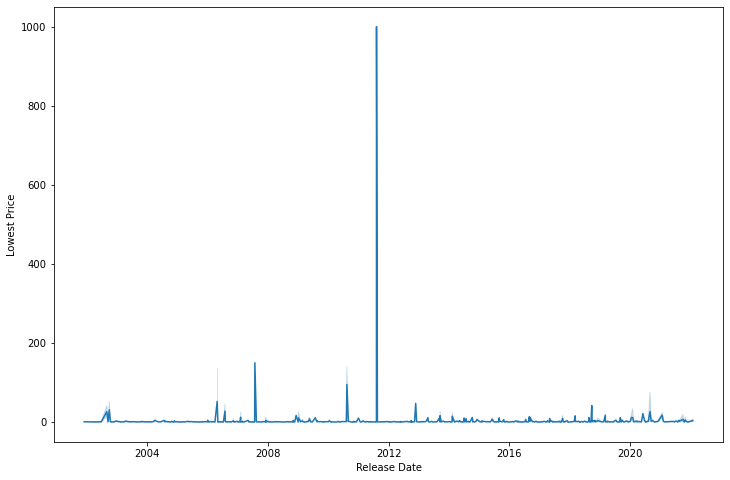

In [19]:
plt.figure(figsize=(12,8))
sns.lineplot(data = ygo, x = 'release_date', y = 'lowest_price')
plt.xlabel('Release Date')
plt.ylabel('Lowest Price')
plt.show()

#looking at this graph it seems like there are some outlier price values that will need addressing

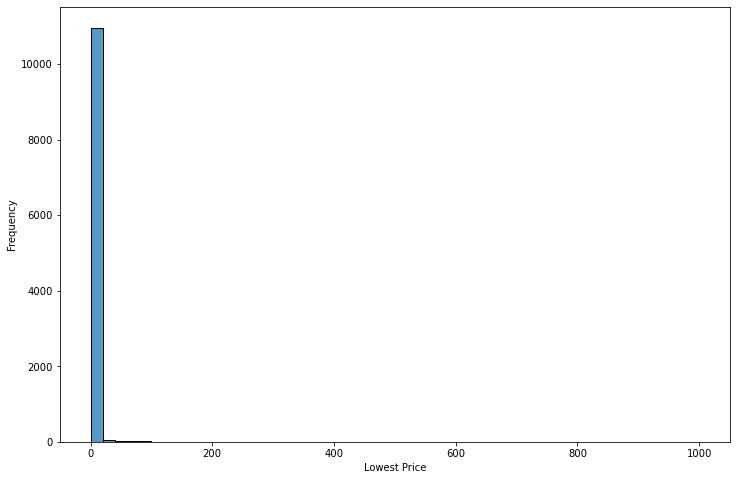

In [20]:
plt.figure(figsize=(12,8))
sns.histplot(data = ygo['lowest_price'], bins=50)
plt.xlabel('Lowest Price')
plt.ylabel('Frequency')
plt.show()


#clearly the outliers are having a detrimental affect on our data and it also seems unlikely that it's a normal distribution

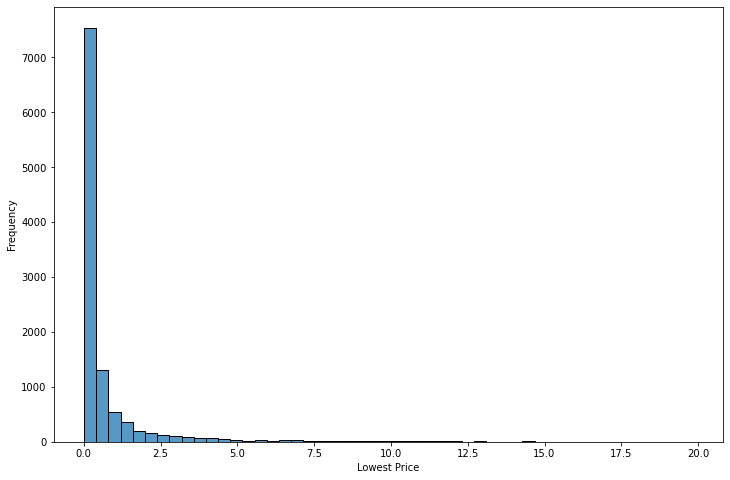

In [21]:
plt.figure(figsize=(12,8))
sns.histplot(data = ygo[ygo.lowest_price <= 20]['lowest_price'], bins=50)
plt.xlabel('Lowest Price')
plt.ylabel('Frequency')
plt.show()

#applying this mask to the data gives us something much more workable although we can see it is clearly far from a normal
#distribution which will make it hard for models to predict
#NB that although we could set the threshold much lower (in fact the majority of the data is below 1) and achieve a 
#distribution closer to a normal it is not anywhere near as useful to predict if a card is a little bit more or less 
#worthless as opposed to trying to predict the standout valuable cards

In [22]:
#this is a good demonstration of why 20 is a good cut off point since it only excludes 100 values but it changes the maximum
#from 1000 to 20

print(ygo.shape)
print(ygo[ygo.lowest_price <= 20].shape)

(11061, 17)
(10961, 17)


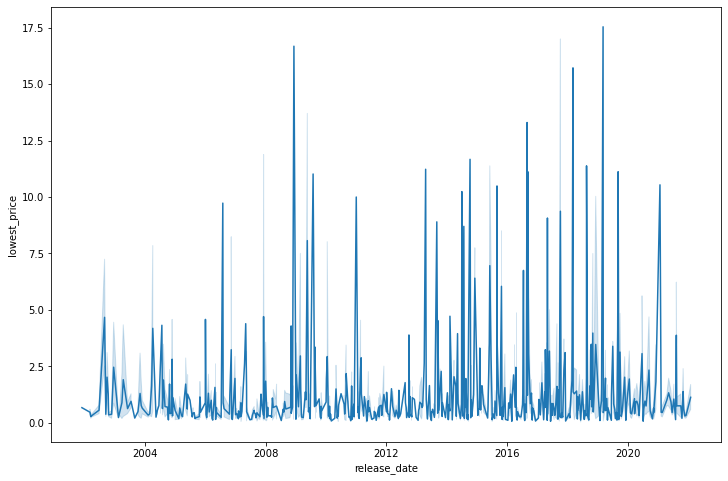

In [23]:
plt.figure(figsize=(12,8))
sns.lineplot(data = ygo[ygo.lowest_price<=20], x = 'release_date', y = 'lowest_price');

#returning to our initial plot we can see the improvements immediately

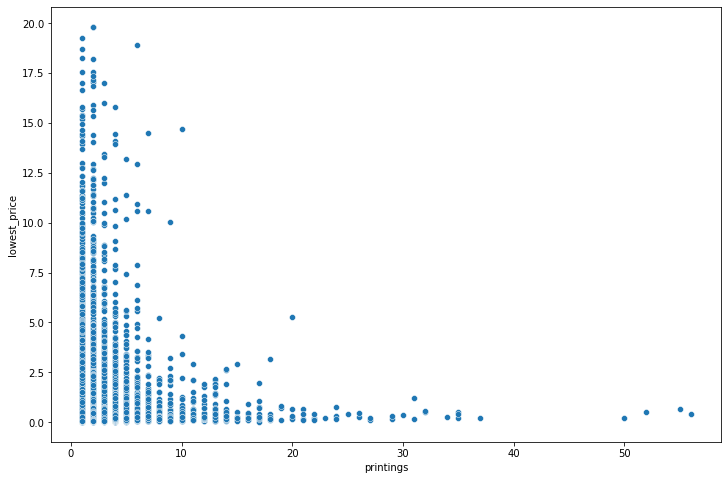

In [24]:
plt.figure(figsize=(12,8))
sns.scatterplot(data = ygo[ygo.lowest_price<=20], x = 'printings', y = 'lowest_price');

#this graph provides somewhat of an affirmation of the earlier assumption that scarcity raises the price as there is an 
#overall negative trend to the price when compared with the number of printings a card has received

#### Dummifying Categorical Features

In [25]:
#we have three main categorical variables and ideally we would like to simplify them somewhat so that we do not have too
#many features before we even begin with NLP, unfortunately it is quite hard to justify simplifications for attribute and 
#type however after acquiring more domain knowledge I have a way to simplify kind which had the worst distribution across 
#its categories of the three

print(len(ygo[ygo.lowest_price<=20].kind.unique()))
print(len(ygo[ygo.lowest_price<=20].attribute.unique()))
print(len(ygo[ygo.lowest_price<=20].type.unique()))

26
9
31


In [26]:
#at the start of every game cards start either in the main deck or the extra deck, main deck cards have to be drawn into the
#hand whereas extra deck cards can be played straightaway, extra deck cards also tend to be boss monsters and have powerful
#effects so should in theory be more valuable than main deck cards

main_deck = ['Effect Monster','Spell Card','Trap Card','Normal Monster','Tuner Monster','Pendulum Effect Monster',
            'Flip Effect Monster','Ritual Effect Monster','Gemini Monster','Union Effect Monster','Pendulum Normal Monster',
            'Spirit Monster','Toon Monster','Ritual Monster','Normal Tuner Monster','Pendulum Tuner Effect Monster',
            'Pendulum Flip Effect Monster']
extra_deck = []

for i in ygo.kind:
    if i in main_deck:
        extra_deck.append(0)
    else:
        extra_deck.append(1)

ygo['extra'] = extra_deck

#this essentially turns kind into a binary variable where 1 means that a card starts a match in the extra deck

In [27]:
#subsequently we can delete the kind column

ygo.drop('kind',axis=1,inplace=True)

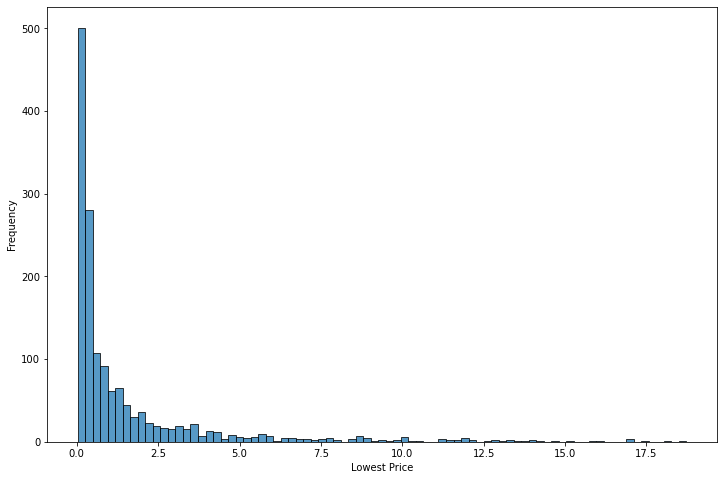

In [28]:
plt.figure(figsize=(12,8))
sns.histplot(ygo[((ygo.lowest_price<=20) & (ygo.extra == 1))]['lowest_price'])
plt.xlabel('Lowest Price')
plt.ylabel('Frequency')
plt.show()

#comparing this graph with previous iterations, clearly extra deck cards tend to make up a larger portion of the more
#valuable cards despite there being fewer of them than main deck cards

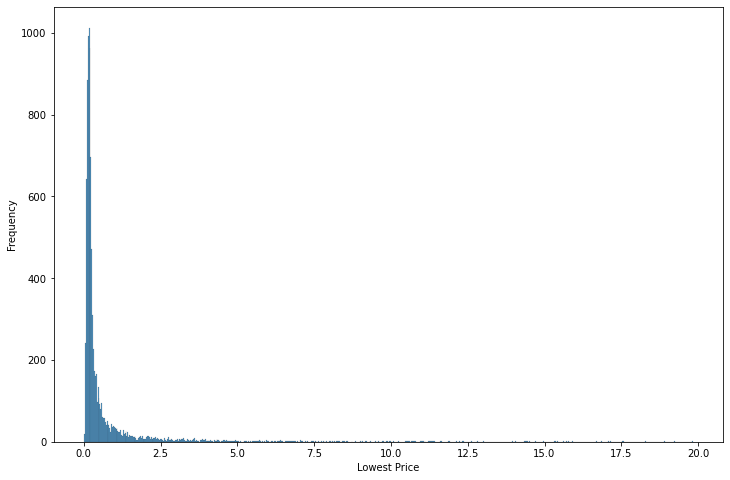

In [29]:
plt.figure(figsize=(12,8))
sns.histplot(ygo[((ygo.lowest_price<=20) & (ygo.extra == 0))]['lowest_price'])
plt.xlabel('Lowest Price')
plt.ylabel('Frequency')
plt.show()

#the equivalent graph for main deck cards backs up the above points further

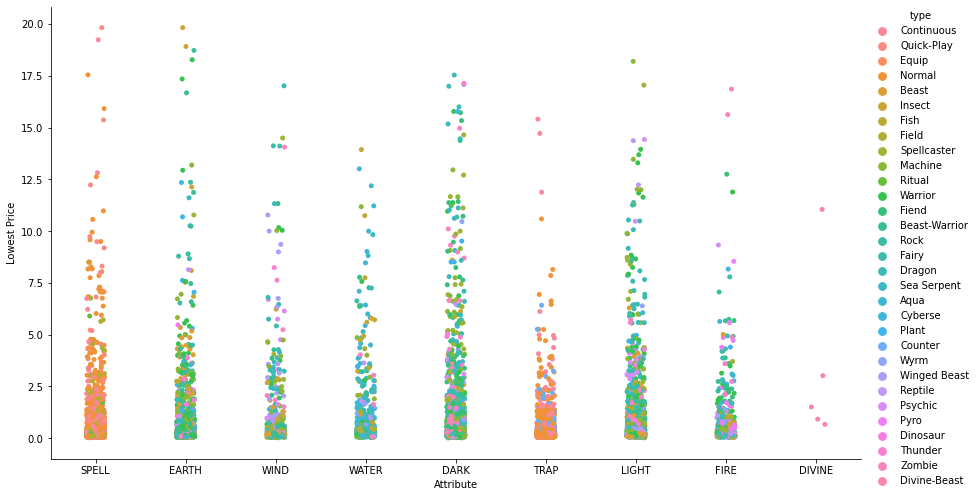

In [30]:
sns.catplot(data = ygo[ygo.lowest_price<=20], x = 'attribute', y = 'lowest_price', hue = 'type', height = 7, aspect = 1.75)
plt.xlabel('Attribute')
plt.ylabel('Lowest Price')
plt.show()

#this graph is very nice for visualising the categorical data remaining before we dummify but as previously mentioned there
#is not a satisfactory way to simplify this data further so we will dummify these two columns

In [31]:
#the time has come to dummify our categorical data and so we also dummify rarities

ygo = pd.get_dummies(ygo,columns=['attribute','type','set_rarities'])

#### Managing the Remaining Columns

In [32]:
ygo[['total_views','views_past_week','lowest_price']].corr()

#as might be expected there is significant correlation between total views and views in the past week, as a result we should
#remove one of them which will be the total views since it has lower correlation with the target variable

,total_views,views_past_week,lowest_price
total_views,1.000000,0.890571,0.041035
views_past_week,0.890571,1.000000,0.071097
lowest_price,0.041035,0.071097,1.000000


In [33]:
ygo.drop('total_views',axis=1,inplace=True)

In [34]:
#since we are about to go into modelling we can drop the remaining columns that will not be used as part of any models (set
#codes and release date) as well as resetting the index

ygo.drop(['release_date','set_codes'],axis=1, inplace=True)
ygo.reset_index(drop=True,inplace=True)

In [35]:
ygo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11061 entries, 0 to 11060
Data columns (total 73 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   name                                             11061 non-null  object 
 1   card_text                                        11061 non-null  object 
 2   effect_or_flavour_text                           11061 non-null  float64
 3   attack                                           11061 non-null  float64
 4   defence                                          11061 non-null  float64
 5   printings                                        11061 non-null  float64
 6   views_past_week                                  11061 non-null  int64  
 7   lowest_price                                     11061 non-null  float64
 8   staple                                           11061 non-null  float64
 9   ban_status                  

### Modelling

In [36]:
#we have our price mask from the EDA and also one for excluding any cards which do not have an effect which we will be 
#applying initially for model construction (in future the models may be run again without these constraints but at present
#they seem reasonable cleaning particularly as the NLP begins)
#While doing so we will also create a new dataframe

price_mask = ygo.lowest_price <= 20
effect_mask = ygo.effect_or_flavour_text == 1

ygo_mask = ygo[price_mask & effect_mask].copy()
ygo_mask.reset_index(drop=True,inplace=True)

#### NLP

In [37]:
#first let's visualise the NLP data using word clouds, we'll need to start by setting stopwords for wordcloud (NB this must 
#be a set)
#this list is also something that will likely change over time and iterations of this project by both adding and removing
#words from the stopwords

stop = wcloud.STOPWORDS
stop.add('per')
stop.add('effect')
stop.add('card')

In [38]:
#we need to gather all the text we want to visualise together, so I have created two separate variables, one for the text in
#the card names the other for the text in the card effects
#naturally you can use masks to get text subsets for example if you only wanted the name data from fiend type monster you
#can use ygo_mask[ygo_mask.type_Fiend==1].name

name_text = ''
for i in ygo_mask.name:
    name_text+=i
text = ''
for i in ygo_mask.card_text:
    text+=i

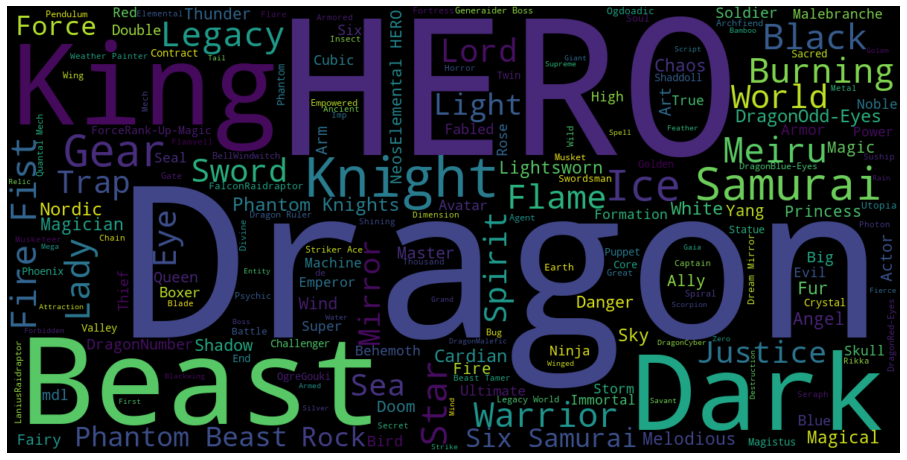

In [39]:
#width and height affect how granular the detail on the canvas is, meanwhile we use a custom bit of regex because cards in
#this game often use terms such as monster(s) and some cards have names including characters such as @ or have acronyms such
#as D/D/D, despite this it is difficult to guarantee that all text data is being parsed correctly
#implementing a stemmer further down the line would probably help also
#NB that wordcloud defaults to a combination of count vectoriser and tf-idf vectoriser which works nicely for our 
#visualisation here but means we will have slightly different results after vectorising later

wordcloud = wcloud.WordCloud(width=1200,height=600,regexp=r"\w[\w'\"()\@\-/]+",stopwords=stop).generate(name_text)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

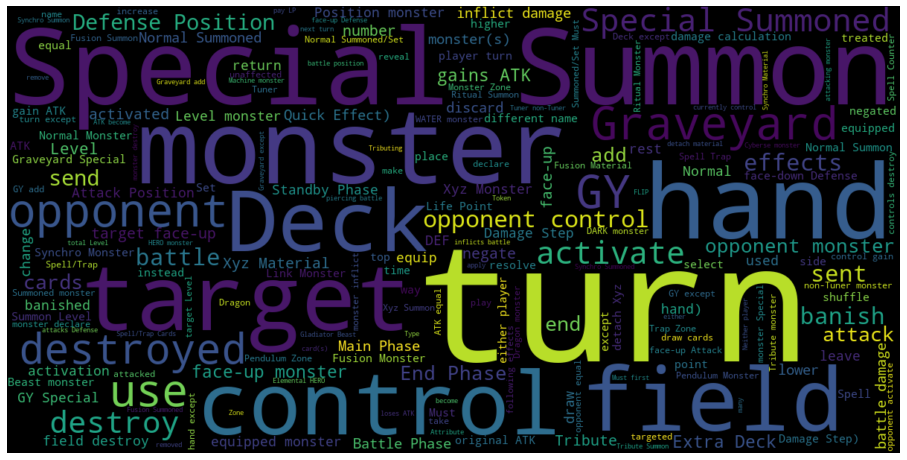

In [40]:
wordcloud = wcloud.WordCloud(width=1200,height=600,regexp=r"\w[\w'()\@\-/]+",stopwords=stop).generate(text)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
#the above give us an idea of what to expect amongst our most common terms when the vectorisers have been applied so now 
#let's vectorise the text data
#the vectoriser of choice is a count vectoriser as there is nothing to suggest that rarer text indicates a more valuable 
#card nor that commonly appearing text should be punished, in fact the opposite could be argued because of the 
#implementation in the game of PSCT(problem solving card text) which aims to standardise the syntax of all text written on
#cards

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

In [42]:
#we need to set a new list of stopwords for the vectoriser, this will also be likely to evolve over time and models

stop = stopwords.words('english')
stop.append('per')
stop.append('card')

In [43]:
#the parameters chosen are intended to try and identify archetype names in the card names with the ngrams at 1-3 and 
#identify statements such as (Quick Effect) in the card texts with ngrams at 1-2
#the min df values meanwhile try to keep the number of features generated to a level below the number of samples ~11000

cvec_name = CountVectorizer(stop_words=stop,ngram_range=(1,3),token_pattern=r"\w[\w'\"()\@\-/]+",min_df=5,max_features=2500)
cvec_text = CountVectorizer(stop_words=stop,ngram_range=(1,2),token_pattern=r"\w[\w'()\@\-/]+",min_df=10,max_features=10000)

cvec_name.fit(ygo_mask['name'])
cvec_text.fit(ygo_mask['card_text'])

CountVectorizer(max_features=10000, min_df=10, ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                token_pattern="\\w[\\w'()\\@\\-/]+")

In [44]:
c_name = cvec_name.transform(ygo_mask['name'])
c_text = cvec_text.transform(ygo_mask['card_text'])

In [45]:
top_name = c_name.sum(axis=0)
pd.DataFrame(top_name, columns=cvec_name.get_feature_names()).transpose().sort_values(by=0, ascending=False)[:20]

#unsurprisingly many of our top 20 terms feature on the wordcloud, something worth noting about the wordcloud is that it 
#does not just fit the terms it finds from biggest to smallest but that the words in it are at sizes relative to one 
#another's frequency, this means that some of the more common terms get left out because they cannot fit on the canvas of
#the wordcloud

,0
dragon,533
dark,210
beast,162
hero,147
number,144
knight,144
king,123
world,115
performapal,91
magician,88


In [46]:
top_text = c_text.sum(axis=0)
pd.DataFrame(top_text, columns=cvec_text.get_feature_names()).transpose().sort_values(by=0, ascending=False)[:20]

#the outcome for this vectoriser is also similar to its wordcloud

,0
monster,14940
turn,8648
special,6791
effect,6340
summon,6207
monsters,6153
hand,5229
target,5062
control,4817
special summon,4794


In [47]:
#now we can recombine all our features into a dataframe we can use for modelling

dfc_name = pd.DataFrame(c_name.todense(),columns=cvec_name.get_feature_names())
dfc_text = pd.DataFrame(c_text.todense(),columns=cvec_text.get_feature_names())
X = pd.concat([ygo_mask,dfc_name,dfc_text],axis=1)

In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10375 entries, 0 to 10374
Columns: 5409 entries, name to zw
dtypes: float64(6), int64(5339), object(2), uint8(62)
memory usage: 423.9+ MB


In [49]:
#at this point we can drop the original text columns from our dataframe as well as the card effect identifier since the mask
#means all the cards here have effects

X.drop(labels=['name','card_text','effect_or_flavour_text'],axis=1,inplace=True)

In [50]:
#we are also able to set our target variable

y = X.pop('lowest_price')

#### Models

NB for the full set of models considered see the Models notebook in part3 (not all of them are covered in detail due to the initial number tested), since not all the models tried are worth covering in this overview.

In [51]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lars,PoissonRegressor,TweedieRegressor,GammaRegressor
from sklearn.ensemble import GradientBoostingRegressor,BaggingRegressor,RandomForestRegressor,StackingRegressor,VotingRegressor

In [52]:
#to start with we need to use a train test split

X_Train,X_Test,y_Train,y_Test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=3)

In [53]:
#we must also scale our data and due to the large number of binary columns I have left the option to try a min max scaler as
#well as the standard one

scaler = StandardScaler()
#scaler = MinMaxScaler()
X_TrSc = scaler.fit_transform(X_Train)
X_TeSc = scaler.transform(X_Test)

In [173]:
#we can use the dummy regressor to demonstrate the baseline score of our model which is useful as a benchmark for examining
#the other models we want to use

dum = DummyRegressor(strategy='mean')

dum.fit(X_TrSc, y_Train)

print("Training Score: ", dum.score(X_TrSc,y_Train))
print("Test Score: ",dum.score(X_TeSc,y_Test))
print("Cross Validation Score: ", cross_val_score(dum,X_TrSc,y_Train).mean())

Training Score:  0.0
Test Score:  -0.00010504637946295858
Cross Validation Score:  -0.0010431560351293


In [132]:
#the first real model we will look at is Lars(least angle regression), this works better than most models with our data 
#because it is specifically designed to be effective on datasets with large numbers of features (something which NLP 
#inevitably produces), the key factor we have to set is the epsilon value which by default is very low and causes 
#convergence issues with our data (this is why for this initial model 0.1234 is used)

lars = Lars(eps=0.1234)

lars.fit(X_TrSc, y_Train)

print("Training Score: ", lars.score(X_TrSc,y_Train))
print("Test Score: ",lars.score(X_TeSc,y_Test))
print("Cross Validation Score: ", cross_val_score(lars,X_TrSc,y_Train).mean())

Training Score:  0.395167472382174
Test Score:  0.1325900432472863
Cross Validation Score:  0.1341340445941716


In [161]:
#lars works by finding the feature most correlated with the target at each step and if multiple features are tied then it 
#proceeds equiangular to them

print(lars.coef_)
print(lars.coef_.max())
print(lars.coef_.min())
print(X.columns[lars.coef_.argmax()])

#we can see that the lars model suggests a card will be more valuable if more people are looking at it (this seems quite 
#reasonable as most products with more interest should be more expensive)

[ 0.05248807  0.         -0.02371403 ...  0.          0.
  0.        ]
0.43467320561074535
-0.14988362104489214
views_past_week


In [163]:
#the remaining three linear models are all based on the Tweedie distribution with Poisson and Gamma being specific instances
#of it where the link parameter is set to log and the power parameter is 1 and 2 respectively, this distribution is 
#effective on our data as it is designed for non-normally distributed data
#the models' predictions are linked to a linear combination of the input variables via an inverse link function (this is 
#better explained in scikit learn's documentation:
#https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-regression)
#it is important to note that by default all these models use D^2 as their scoring metric which is fairly similar to r^2, 
#but for simplicity's sake and in order to compare better I will use r^2

Poisson = PoissonRegressor()

Poisson.fit(X_TrSc, y_Train)

P_train_preds = Poisson.predict(X_TrSc)
P_test_preds = Poisson.predict(X_TeSc)

print("Training Score: ", r2_score(y_Train,P_train_preds))
print("Test Score: ",r2_score(y_Test,P_test_preds))
print("Cross Validation Score: ", cross_val_score(Poisson,X_TrSc,y_Train,scoring='r2').mean())

Training Score:  0.7317821666314828
Test Score:  0.15119839890861586
Cross Validation Score:  0.10097890863521342


In [166]:
print(Poisson.coef_)
print(Poisson.coef_.max())
print(Poisson.coef_.min())
print(X.columns[Poisson.coef_.argmax()])

[ 0.02908678  0.01059379 -0.01642187 ...  0.00146041  0.00542182
  0.00142775]
0.12373886221255735
-0.12046680432126937
set_rarities_Ultra Rare


In [164]:
#the chosen parameters for this initial tweedie model place it inbetween the Poisson and Gamma

Tweedie = TweedieRegressor(link='log', power=1.5)

Tweedie.fit(X_TrSc, y_Train)

T_train_preds = Tweedie.predict(X_TrSc)
T_test_preds = Tweedie.predict(X_TeSc)

print("Training Score: ", r2_score(y_Train,T_train_preds))
print("Test Score: ",r2_score(y_Test,T_test_preds))
print("Cross Validation Score: ", cross_val_score(Tweedie,X_TrSc,y_Train,scoring='r2').mean())

Training Score:  0.564139517028648
Test Score:  0.1475488986583191
Cross Validation Score:  0.1170400290393205


In [172]:
print(Tweedie.coef_)
print(Tweedie.coef_.max())
print(Tweedie.coef_.min())
print(X.columns[Tweedie.coef_.argmin()])

[ 0.02859341  0.01059636 -0.01023718 ...  0.00186959  0.00537258
  0.00251717]
0.12139401332978322
-0.12515470471353984
set_rarities_Common


In [165]:
Gamma = GammaRegressor()

Gamma.fit(X_TrSc, y_Train)

G_train_preds = Gamma.predict(X_TrSc)
G_test_preds = Gamma.predict(X_TeSc)

print("Training Score: ", r2_score(y_Train,G_train_preds))
print("Test Score: ",r2_score(y_Test,G_test_preds))
print("Cross Validation Score: ", cross_val_score(Gamma,X_TrSc,y_Train,scoring='r2').mean())

Training Score:  0.42344546539577355
Test Score:  0.12436909870853485
Cross Validation Score:  0.10775172299934818


In [170]:
print(Gamma.coef_)
print(Gamma.coef_.max())
print(Gamma.coef_.min())
print(X.columns[Gamma.coef_.argmin()])

[ 0.02857208  0.01007962 -0.00352781 ...  0.00234926  0.00548884
  0.00337124]
0.1281502407894582
-0.1394549317630303
set_rarities_Common


In [ ]:
#interestingly all three Tweedie based models have common rarity as the largest negative coefficient and ultra rare rarity
#as the largest positive these rarities are theoretically amongst the lowest and highest respectively but also both are 
#significantly well represented in the data making them very reasonable choices for most important features

In [174]:
#for our ensemble models we will be using a bagging regressor, random forest regressor and gradient boosting regressor,
#unsurprisingly the models which run multiple iterations are also amongst those that work best on our target variable
#the initial versions of these will be fairly default but future gridsearching with all three will try more expansive 
#options and potentially lead into stacking and voting models further down the line (time permitting), a depth of seven is 
#chosen because it should produce roughly 100 nodes at the base of the tree which splits the data into 1% groups

Bag = BaggingRegressor(DecisionTreeRegressor(max_depth=7))

Bag.fit(X_TrSc, y_Train)

print("Training Score: ", Bag.score(X_TrSc,y_Train))
print("Test Score: ",Bag.score(X_TeSc,y_Test))
print("Cross Validation Score: ", cross_val_score(Bag,X_TrSc,y_Train).mean())

Training Score:  0.45356994868119327
Test Score:  0.1409133199722733
Cross Validation Score:  0.16581942643549982


In [188]:
#we can unpack the most important features from our bagging model with a for loop like so:

for est in Bag.estimators_:
    print(est.feature_importances_.max())
    print(est.feature_importances_.argmax())
    print(X.columns[est.feature_importances_.argmax()])
    
#several familiar features from the previous models appear again here

0.2141031351137966
3
views_past_week
0.2537313653599703
3
views_past_week
0.17570244496606052
48
set_rarities_Common
0.24777970081167186
3
views_past_week
0.2604552318260862
3
views_past_week
0.16080406376039064
48
set_rarities_Common
0.16437381438093274
3
views_past_week
0.1584542731790539
3
views_past_week
0.22972545595342864
3
views_past_week
0.21653588688554223
3
views_past_week


In [189]:
#the idea behind the depth here is the same as for the bagging regressor above while the model itself should similarly work
#better than others due to the number of iterations

Forest = RandomForestRegressor(max_depth=7)

Forest.fit(X_TrSc, y_Train)

print("Training Score: ", Forest.score(X_TrSc,y_Train))
print("Test Score: ",Forest.score(X_TeSc,y_Test))
print("Cross Validation Score: ", cross_val_score(Forest,X_TrSc,y_Train).mean())

Training Score:  0.45449609990839746
Test Score:  0.17149629427604107
Cross Validation Score:  0.17774046423601467


In [192]:
print(Forest.feature_importances_.max())
print(Forest.feature_importances_.argmax())
print(X.columns[Forest.feature_importances_.argmax()])

#once again views rises to the top of the features

0.18929687625086358
3
views_past_week


In [190]:
#our final model that we will cover in this initial section of modelling is the gradient boosting regressor which builds 
#models one on top of the other to try and minimise a loss function (by default the squared error)

Grad = GradientBoostingRegressor()

Grad.fit(X_TrSc, y_Train)

print("Training Score: ", Grad.score(X_TrSc,y_Train))
print("Test Score: ",Grad.score(X_TeSc,y_Test))
print("Cross Validation Score: ", cross_val_score(Grad,X_TrSc,y_Train).mean())

Training Score:  0.4965907265478364
Test Score:  0.1375085120724846
Cross Validation Score:  0.18442267267314416


In [194]:
print(Grad.feature_importances_.max())
print(Grad.feature_importances_.argmax())
print(X.columns[Grad.feature_importances_.argmax()])

0.23390787148532674
3
views_past_week


#### Model Tuning

In [55]:
#now we are going to use gridsearch to try to optimise our models
#NB that because poisson and gamma are specific instances of tweedie we are only going to consider tweedie for gridsearch

from sklearn.model_selection import GridSearchCV

In [55]:
#Lars
#fit path has been set to false for the gridsearch in order to speed up modelling time

params_lars = {'fit_intercept':[True,False],
              'normalize':[True,False],
              'fit_path':[False],
              'n_nonzero_coefs':[250,500,750,1000],
              'eps':[0.01,0.05,0.1,0.2,0.3]}

gslars = Lars()
gs_lars = GridSearchCV(gslars, params_lars, n_jobs=-3, cv=5, scoring='r2', verbose=1)

In [56]:
gs_lars.fit(X_TrSc,y_Train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=Lars(), n_jobs=-3,
             param_grid={'eps': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'fit_intercept': [True, False], 'fit_path': [False],
                         'n_nonzero_coefs': [250, 500, 750, 1000],
                         'normalize': [True, False]},
             scoring='r2', verbose=1)

In [57]:
print("Best Score: ", gs_lars.best_score_)
print("Training Score: ", gs_lars.score(X_TrSc, y_Train))
print("Test Score: ", gs_lars.score(X_TeSc, y_Test))
print("Best model: ", gs_lars.best_estimator_)

Best Score:  0.1766732617055166
Training Score:  0.33773849767460906
Test Score:  0.15060414911892994
Best model:  Lars(eps=0.1, fit_path=False, n_nonzero_coefs=250, normalize=False)


In [129]:
#Tweedie
#as before we make sure to specify the scoring metric here since we want to compare r^2 scores not D^2
#according to scikit learn grid search is not currently supported for tweedie distributions so we may just have to 
#experiment manually

params_tweedie = {'power':[1,1.2,1.4,1.5,1.6,1.8,2,3],
                 'alpha':[0.5,1,2,5,10],
                 'link':['log']
                 }

gstweedie = TweedieRegressor()
gs_tweedie = GridSearchCV(gstweedie, params_tweedie, n_jobs=-3, cv=5, scoring='r2', verbose=1)

In [130]:
gs_tweedie.fit(X_TrSc,y_Train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=TweedieRegressor(), n_jobs=-3,
             param_grid={'alpha': [0.5, 1, 2, 5, 10], 'link': ['log'],
                         'power': [1, 1.2, 1.4, 1.5, 1.6, 1.8, 2, 3]},
             scoring='r2', verbose=1)

In [131]:
print("Best Score: ", gs_tweedie.best_score_)
print("Training Score: ", gs_tweedie.score(X_TrSc, y_Train))
print("Test Score: ", gs_tweedie.score(X_TeSc, y_Test))
print("Best model: ", gs_tweedie.best_estimator_)

#all these results seem reasonable so the gridsearch must be working for the tweedie models now

Best Score:  0.11844971252857033
Training Score:  0.5297177774126696
Test Score:  0.15096738568177714
Best model:  TweedieRegressor(alpha=2, link='log', power=1.2)


In [132]:
#optimising a decision tree for use in the bagging regressor

params_tree = {'criterion':['squared_error','friedman_mse'],
               'splitter':['best','random'], 
               'max_depth':[5,6,7,8,9,10], 
               'max_features':['sqrt','auto']
                 }

gstree = DecisionTreeRegressor()
gs_tree = GridSearchCV(gstree, params_tree, n_jobs=-3, cv=5, scoring='r2', verbose=1)

In [133]:
gs_tree.fit(X_TrSc,y_Train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\georg\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.03132353 -0.0186337   0.07259429  0.02930574 -0.01708629 -0.02568397
  0.02559825 -0.01082104 -0.0135375  -0.06798635  0.03169323 -0.05676393
 -0.04776975 -0.0931178  -0.04685338 -0.05385997 -0.04556338 -0.06831877
 -0.11228412 -0.19002587 -0.08685206 -0.04806748 -0.08864711 -0.11829632]
  warnings.warn(


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-3,
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [5, 6, 7, 8, 9, 10],
                         'max_features': ['sqrt', 'auto'],
                         'splitter': ['best', 'random']},
             scoring='r2', verbose=1)

In [134]:
#having run the gridsearch we might as well check the best results as well as getting the best model

print("Best Score: ", gs_tree.best_score_)
print("Training Score: ", gs_tree.score(X_TrSc, y_Train))
print("Test Score: ", gs_tree.score(X_TeSc, y_Test))
print("Best model: ", gs_tree.best_estimator_)

Best Score:  0.07259428679914652
Training Score:  0.3184063497730085
Test Score:  0.08749061314157924
Best model:  DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                      max_features='auto')


In [56]:
#Bagging for our base models we will be using the ones optimised above

params_bagging = {'base_estimator':[Lars(eps=0.1, fit_path=False, n_nonzero_coefs=250, normalize=False),
                                    TweedieRegressor(link='log', power=1.2, alpha=2),
                                    DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,max_features='auto')
                                    ],
                 'n_estimators':[10,25,50,100],
                 'max_samples':[0.5,0.75,1],
                 'max_features':[0.5,0.75,1],
                 'bootstrap':[True,False],
                 'bootstrap_features':[True,False],
                 'oob_score':[True,False]
                 }

gsbagging = BaggingRegressor()
gs_bagging = GridSearchCV(gsbagging, params_bagging, n_jobs=-3, cv=5, scoring='r2', verbose=1)

In [57]:
gs_bagging.fit(X_TrSc,y_Train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


C:\Users\georg\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [            nan  1.18603761e-01             nan -8.98551136e+06
             nan -4.12290593e+05             nan -3.72408880e+05
             nan  1.44039910e-01             nan -2.07924929e+01
             nan -5.11692167e+04             nan -2.36394330e+02
             nan -6.28639057e-02             nan -5.54489436e-02
             nan -5.16242232e-03             nan -8.29778158e-03
             nan -5.98224456e+06             nan -4.47718613e+06
             nan -3.47663189e+09             nan -1.04634139e+06
             nan  1.41900458e-01             nan  1.52221407e-01
             nan  1.62674790e-01             nan -4.08803118e+04
             nan -4.76782100e-02             nan -1.81443664e-02
             nan -1.92693203e-02             nan -3.14030549e-02
             nan -7.76009309e-04             nan -8.40801071e-04
            

GridSearchCV(cv=5, estimator=BaggingRegressor(), n_jobs=-3,
             param_grid={'base_estimator': [Lars(eps=0.1, fit_path=False,
                                                 n_nonzero_coefs=250,
                                                 normalize=False),
                                            TweedieRegressor(alpha=2,
                                                             link='log',
                                                             power=1.2),
                                            DecisionTreeRegressor(criterion='friedman_mse',
                                                                  max_depth=5,
                                                                  max_features='auto')],
                         'bootstrap': [True, False],
                         'bootstrap_features': [True, False],
                         'max_features': [0.5, 0.75, 1],
                         'max_samples': [0.5, 0.75, 1],
                         

In [58]:
print("Best Score: ", gs_bagging.best_score_)
print("Training Score: ", gs_bagging.score(X_TrSc, y_Train))
print("Test Score: ", gs_bagging.score(X_TeSc, y_Test))
print("Best model: ", gs_bagging.best_estimator_)

Best Score:  0.17445210729141078
Training Score:  0.3623611478374664
Test Score:  0.15969978609322033
Best model:  BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                      max_depth=5,
                                                      max_features='auto'),
                 bootstrap=False, max_features=0.75, max_samples=0.75,
                 n_estimators=50)


In [56]:
#RandomForest
#interestingly enough friedman mse is not in the scikit learn docs but seems to have worked, most likely it just selected 
#mse anyway which is usually the same as squared error for scikit learn

params_forest = {'n_estimators':[10,25,50,100,150],
                 'criterion':['squared_error','friedman_mse'],
                 'max_depth':[5,7,10],
                 'max_features':['sqrt','auto'],
                 'bootstrap':[True,False],
                 'oob_score':[True,False],
                 'max_samples':[0.5,0.75,1]
                 }

gsforest = RandomForestRegressor()
gs_forest = GridSearchCV(gsforest, params_forest, n_jobs=-3, cv=5, scoring='r2', verbose=1)

In [57]:
gs_forest.fit(X_TrSc,y_Train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


C:\Users\georg\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan      

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-3,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': [5, 7, 10],
                         'max_features': ['sqrt', 'auto'],
                         'max_samples': [0.5, 0.75, 1],
                         'n_estimators': [10, 25, 50, 100, 150],
                         'oob_score': [True, False]},
             scoring='r2', verbose=1)

In [58]:
print("Best Score: ", gs_forest.best_score_)
print("Training Score: ", gs_forest.score(X_TrSc, y_Train))
print("Test Score: ", gs_forest.score(X_TeSc, y_Test))
print("Best model: ", gs_forest.best_estimator_)

#while the best/training score of this random forest is an improvement the test score is not, this is likely due to 
#overfitting the model to the training data in the gridsearch process, thus the results we will take forward are those from 
#the initial model (it is unlikely at present that we will manually gridsearch the random forest model due to time and 
#computing resource constraints)

Best Score:  0.1880291109462317
Training Score:  0.48798809939290066
Test Score:  0.15694248758679052
Best model:  RandomForestRegressor(criterion='friedman_mse', max_depth=10, max_samples=0.5,
                      oob_score=True)


In [66]:
#GradientBoosting

params_gradient = {'n_estimators':[100,175,250],
                   'learning_rate':[0.05,0.1,0.2],
                   'max_depth':[3,5,7,10],
                   'init':[None,'zero',Lars(eps=0.1, fit_path=False, n_nonzero_coefs=250, normalize=False),
                                    TweedieRegressor(link='log', power=1.2, alpha=2),
                                    DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,max_features='auto')],
                   'n_iter_no_change':[10]
                 }

gsgradient = GradientBoostingRegressor()
gs_gradient = GridSearchCV(gsgradient, params_gradient, n_jobs=-3, cv=5, scoring='r2', verbose=1)

In [67]:
gs_gradient.fit(X_TrSc,y_Train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-3,
             param_grid={'init': [None, 'zero',
                                  Lars(eps=0.9, fit_path=False,
                                       n_nonzero_coefs=250, normalize=False),
                                  TweedieRegressor(alpha=2, link='log',
                                                   power=1.2),
                                  DecisionTreeRegressor(criterion='friedman_mse',
                                                        max_depth=5,
                                                        max_features='auto')],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 175, 250],
                         'n_iter_no_change': [10]},
             scoring='r2', verbose=1)

In [68]:
print("Best Score: ", gs_gradient.best_score_)
print("Training Score: ", gs_gradient.score(X_TrSc, y_Train))
print("Test Score: ", gs_gradient.score(X_TeSc, y_Test))
print("Best model: ", gs_gradient.best_estimator_)

Best Score:  0.19317576697849825
Training Score:  0.41630099509728047
Test Score:  0.1261028076006495
Best model:  GradientBoostingRegressor(init='zero', learning_rate=0.05, n_estimators=175,
                          n_iter_no_change=10)


It seems across the various gridsearches that many result in an improved cross validated score (best score in the output) but a worse test score. This is likely to be the result of models overfitting onto the training data no longer being able to function as well on the test data which we are more interested in scoring well on. Unfortunately trying to manually tune all these models instead, will be very computationally intensive and take quite some time meaning that we will have to stick with the results we already have for now.

#### Model Evaluation

In [69]:
#selecting the best instances of models from the gridsearches and initial versions we have

LARS = Lars(eps=0.1, n_nonzero_coefs=250, normalize=False)

TWEEDIE = TweedieRegressor(alpha=2, link='log', power=1.2)

BAGGING = BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                      max_depth=5,
                                                      max_features='auto'),
                 bootstrap=False, max_features=0.75, max_samples=0.75, n_estimators=50)

FOREST = RandomForestRegressor(max_depth=7)

GRADIENT = GradientBoostingRegressor()

LARS.fit(X_TrSc,y_Train)
TWEEDIE.fit(X_TrSc,y_Train)
BAGGING.fit(X_TrSc,y_Train)
FOREST.fit(X_TrSc,y_Train)
GRADIENT.fit(X_TrSc,y_Train)

GradientBoostingRegressor()

In [76]:
LARS.intercept_

0.7822313253012048

In [112]:
LARS.coef_path_

array([[ 0.        ,  0.        ,  0.        , ...,  0.04573117,
         0.04579906,  0.04580284],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.002884  ,
        -0.00315919, -0.00317319],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [75]:
LARS.active_

[3,
 48,
 68,
 61,
 6,
 0,
 67,
 3261,
 818,
 4334,
 572,
 4829,
 3550,
 5,
 2348,
 4788,
 4398,
 56,
 1184,
 1817,
 1014,
 54,
 1421,
 3103,
 2420,
 3861,
 2663,
 774,
 2200,
 3236,
 383,
 977,
 427,
 381,
 978,
 1229,
 109,
 60,
 2380,
 4601,
 4141,
 3039,
 4756,
 7,
 502,
 1953,
 1595,
 400,
 1016,
 4808,
 409,
 4585,
 5367,
 65,
 2737,
 3565,
 1693,
 213,
 2177,
 1419,
 2434,
 2680,
 1380,
 2150,
 1275,
 5190,
 1017,
 719,
 917,
 1072,
 4511,
 5332,
 371,
 235,
 8,
 1507,
 1508,
 4898,
 382,
 4280,
 335,
 3464,
 2605,
 2186,
 489,
 450,
 2086,
 4818,
 1434,
 1373,
 1019,
 3610,
 4642,
 3971,
 2292,
 4215,
 5034,
 2202,
 1294,
 2327,
 4577,
 1013,
 1132,
 3667,
 3454,
 5268,
 1400,
 4797,
 3555,
 2493,
 5246,
 4541,
 2911,
 607,
 294,
 4407,
 2835,
 625,
 3528,
 3374,
 3184,
 3736,
 4105,
 1469,
 4242,
 46,
 3795,
 3561,
 4684,
 5046,
 3229,
 21,
 59,
 2084,
 4820,
 4090,
 2677,
 915,
 3995,
 554,
 1445,
 710,
 784,
 3478,
 4072,
 4643,
 277,
 1038,
 378,
 3997,
 1466,
 1889,
 893,


In [136]:
Lars_coef = pd.DataFrame(list(zip(X.columns, LARS.coef_)), 
             columns=['Feature', 'Coefficient']
            )
Lars_coef

,Feature,Coefficient
0,attack,0.045803
1,defence,0.000000
2,printings,-0.003173
3,views_past_week,0.416396
4,staple,0.000000
...,...,...
5399,zones,0.000000
5400,zones cannot,0.000000
5401,zoodiac,0.000000
5402,zoodiac monster,0.000000


In [84]:
for i in ygo['name']:
    if 'Magical Musket' in i:
        print(i)

Magical Musket - Crooked Crown
Magical Musket - Cross-Domination
Magical Musket - Dancing Needle
Magical Musket - Desperado
Magical Musket - Fiendish Deal
Magical Musket - Last Stand
Magical Musket - Steady Hands
Magical Musket Mastermind Zakiel
Magical Musketeer Calamity
Magical Musketeer Caspar
Magical Musketeer Doc
Magical Musketeer Kidbrave
Magical Musketeer Max
Magical Musketeer Starfire
Magical Musketeer Wild


In [104]:
ygo[ygo.name == 'Magical Musket - Cross-Domination']

,name,card_text,effect_or_flavour_text,attack,defence,printings,views_past_week,lowest_price,staple,ban_status,...,set_rarities_Prismatic Secret Rare,set_rarities_Rare,set_rarities_Secret Rare,set_rarities_Shatterfoil Rare,set_rarities_Short Print,set_rarities_Starfoil Rare,set_rarities_Super Rare,set_rarities_Super Short Print,set_rarities_Ultimate Rare,set_rarities_Ultra Rare
5780,Magical Musket - Cross-Domination,"If you control a ""Magical Musket"" monster: Tar...",1.0,0.0,0.0,1.0,265,9.19,0.0,3,...,0,0,1,0,0,0,0,0,0,0


In [148]:
std_dev =[]
for i in X.std():
    std_dev.append(i)
std_dev

[1043.896807995137,
 906.3112601183193,
 2.6868523442669927,
 1135.5832962245001,
 0.07195990716877397,
 0.3378023794675831,
 0.3468536847333909,
 0.3792727413113668,
 0.021948619306874348,
 0.350617290118006,
 0.2265509004526081,
 0.3428050856951872,
 0.4047124740802333,
 0.36742637258159316,
 0.24077284873003982,
 0.24217109556466831,
 0.12769120703179654,
 0.1662164871161689,
 0.13884483743902437,
 0.27085807364809117,
 0.1161926039779382,
 0.14050151954227771,
 0.09324693286252832,
 0.021948619306874348,
 0.22540935534089673,
 0.1521541017824846,
 0.19664604669739966,
 0.15094180176988034,
 0.2375875587492993,
 0.09119224964833875,
 0.13580758303744297,
 0.2672341420049994,
 0.38750286851304927,
 0.13477871508890202,
 0.11937410083265651,
 0.0977065639609532,
 0.1868981627256558,
 0.11699656573849063,
 0.08069626236982727,
 0.13750390509667587,
 0.08128350827409456,
 0.22560011694882046,
 0.10009507211781275,
 0.27660447066586136,
 0.15748233450402577,
 0.08471924358601476,
 0.1316

In [149]:
Lars_coef['Standard Deviation'] = std_dev

In [151]:
Lars_coef['Value Added'] = (Lars_coef['Coefficient']/Lars_coef['Standard Deviation'])

In [165]:
Lars_coef.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient,Standard Deviation,Value Added
710,magical musket,7764.609258,0.027759,279714.665531
3,views_past_week,0.416396,1135.583296,0.000367
61,set_rarities_Secret Rare,0.324488,0.168658,1.923945
68,set_rarities_Ultra Rare,0.317988,0.286919,1.108285
67,set_rarities_Ultimate Rare,0.092182,0.024042,3.834132
...,...,...,...,...
5,ban_status,-0.051637,0.337802,-0.152862
6,extra,-0.060368,0.346854,-0.174044
3103,gy,-0.064366,0.773215,-0.083245
48,set_rarities_Common,-0.151441,0.489644,-0.309287


In [163]:
Lars_coef.sort_values(by='Value Added', ascending=False)

,Feature,Coefficient,Standard Deviation,Value Added
710,magical musket,7764.609258,0.027759,279714.665531
56,set_rarities_Normal Parallel Rare,0.065571,0.009818,6.678903
67,set_rarities_Ultimate Rare,0.092182,0.024042,3.834132
1184,victory,0.057323,0.021949,2.611677
572,head,0.060067,0.024042,2.498363
...,...,...,...,...
625,invoked,-0.012186,0.025967,-0.469288
294,cxyz,-0.014061,0.027759,-0.506536
2605,effects effects,-0.031017,0.033991,-0.912505
784,musket,-7764.599263,0.027759,-279714.305479


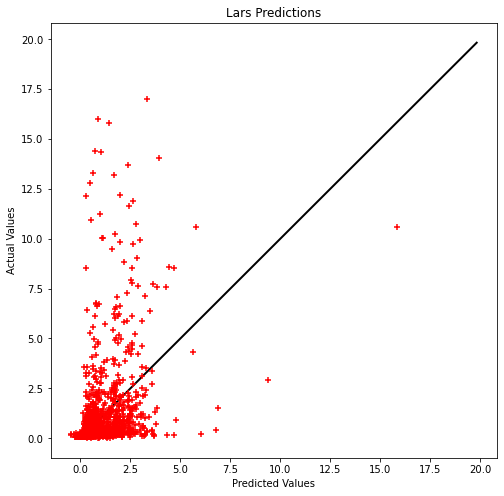

In [175]:
Lars_preds = LARS.predict(X_TeSc)

plt.figure(figsize=(8, 8))
plt.scatter(Lars_preds, y_Test, s=30, c='r', marker='+', zorder=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c='k', lw=2)
plt.title("Lars Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [105]:
TWEEDIE.intercept_

-0.5405210204521204

In [158]:
Tweedie_coef = pd.DataFrame(list(zip(X.columns, TWEEDIE.coef_)), 
             columns=['Feature', 'Coefficient']
            )
Tweedie_coef

,Feature,Coefficient
0,attack,0.024151
1,defence,0.011408
2,printings,-0.010992
3,views_past_week,0.082550
4,staple,0.023985
...,...,...
5399,zones,-0.002528
5400,zones cannot,0.004774
5401,zoodiac,0.000710
5402,zoodiac monster,0.002736


In [159]:
Tweedie_coef['Standard Deviation'] = std_dev

In [160]:
Tweedie_coef['Value Added'] = (Tweedie_coef['Coefficient']/Tweedie_coef['Standard Deviation'])

In [164]:
Tweedie_coef.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient,Standard Deviation,Value Added
68,set_rarities_Ultra Rare,0.088179,0.286919,0.307331
3,views_past_week,0.082550,1135.583296,0.000073
61,set_rarities_Secret Rare,0.076780,0.168658,0.455241
6,extra,0.029663,0.346854,0.085519
0,attack,0.024151,1043.896808,0.000023
...,...,...,...,...
4898,target,-0.011689,0.774088,-0.015100
60,set_rarities_Rare,-0.013212,0.298142,-0.044316
13,attribute_TRAP,-0.019351,0.367426,-0.052668
5,ban_status,-0.034100,0.337802,-0.100948


In [162]:
Tweedie_coef.sort_values(by='Value Added', ascending=False)

,Feature,Coefficient,Standard Deviation,Value Added
56,set_rarities_Normal Parallel Rare,0.012152,0.009818,1.237769
572,head,0.021476,0.024042,0.893277
67,set_rarities_Ultimate Rare,0.021079,0.024042,0.876726
383,drake,0.016280,0.021949,0.741722
109,arm,0.016116,0.021949,0.734264
...,...,...,...,...
5177,turn pendulum,-0.007621,0.031033,-0.245577
370,dragon ice,-0.005749,0.021949,-0.261930
423,eternal,-0.008679,0.032546,-0.266671
488,fortune fairy,-0.007181,0.024042,-0.298668


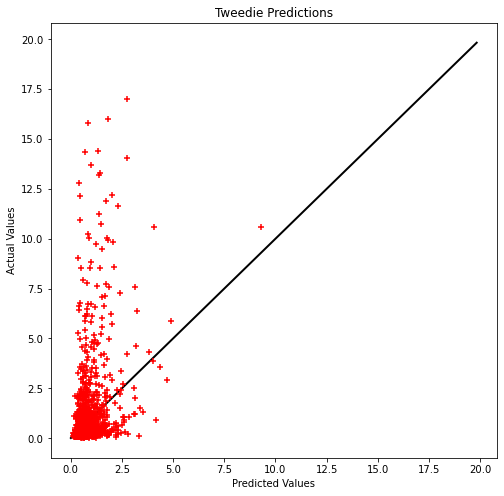

In [176]:
Tweedie_preds = TWEEDIE.predict(X_TeSc)

plt.figure(figsize=(8, 8))
plt.scatter(Tweedie_preds, y_Test, s=30, c='r', marker='+', zorder=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c='k', lw=2)
plt.title("Tweedie Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [60]:
BAGGING.estimators_

[DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                       max_features='auto', random_state=2013681381),
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                       max_features='auto', random_state=991909219),
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                       max_features='auto', random_state=418640727),
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                       max_features='auto', random_state=2050448953),
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                       max_features='auto', random_state=487422746),
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                       max_features='auto', random_state=1608168260),
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                       max_features='auto', random_state=1963034055),
 DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                 

In [63]:
for est in BAGGING.estimators_:
    print(est.feature_importances_.max())
    print(est.feature_importances_.argmax())
    print(X.columns[est.feature_importances_.argmax()])
    
#create a table for these then aggregate to get a table of feature importances

0.28788760536020935
2434
draw phase
0.3096665635920266
2672
equal original
0.25991993619711684
3502
loses 800
0.24783829904961405
956
saga
0.3079001976998753
3416
level dark
0.2690452699138622
3580
malebranche burning
0.24014408643600896
978
secret six samurai
0.2968966096891058
1104
sylvan
0.30950488826948586
3262
heads
0.37923761132058825
3193
hand different
0.27319064740607646
1703
banishing
0.23944102519835853
259
coach
0.3029087296899779
1576
atk sent
0.2874568913400691
2107
counter
0.3242878754320441
290
current
0.2504287266622768
2983
gains 2000
0.27132539251675103
3067
graveyard monsters
0.29623410530403876
2300
destroy inflict
0.3181600104424128
416
empress
0.31115702945360135
614
infernity
0.24350960267555108
3534
lunalight monster
0.25626073085695006
2291
destroy control
0.2457064029792594
2010
control extra
0.23255325971354374
2364
dinosaur
0.32369703282455164
1477
altergeist
0.25133107127007137
3974
non-tuner synchro
0.32391029080830536
791
mythical beast
0.272810152836338

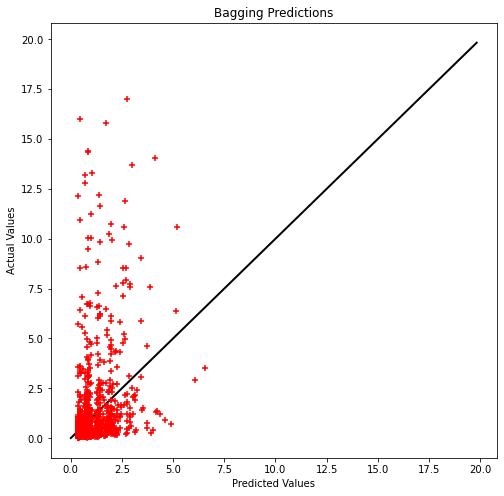

In [64]:
Bagging_preds = BAGGING.predict(X_TeSc)

plt.figure(figsize=(8, 8))
plt.scatter(Bagging_preds, y_Test, s=30, c='r', marker='+', zorder=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c='k', lw=2)
plt.title("Bagging Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [127]:
FOREST.feature_importances_

array([0.00385698, 0.0025528 , 0.00160029, ..., 0.        , 0.        ,
       0.        ])

In [133]:
Forest_importances = pd.DataFrame(list(zip(X.columns, FOREST.feature_importances_)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)
Forest_importances

,Feature,Importance
3,views_past_week,0.186696
48,set_rarities_Common,0.135418
61,set_rarities_Secret Rare,0.066732
68,set_rarities_Ultra Rare,0.036921
381,dragunity knight,0.018206
...,...,...
2352,die result,0.000000
2353,difference,0.000000
2354,difference battle,0.000000
543,gorgonic,0.000000


In [180]:
Forest_importances[Forest_importances.Importance>0]

,Feature,Importance
3,views_past_week,1.866957e-01
48,set_rarities_Common,1.354183e-01
61,set_rarities_Secret Rare,6.673247e-02
68,set_rarities_Ultra Rare,3.692148e-02
381,dragunity knight,1.820553e-02
...,...,...
2667,equal half,1.360860e-09
2226,deck rest,1.002903e-09
3904,must first,9.962985e-10
4502,send graveyard,7.329810e-10


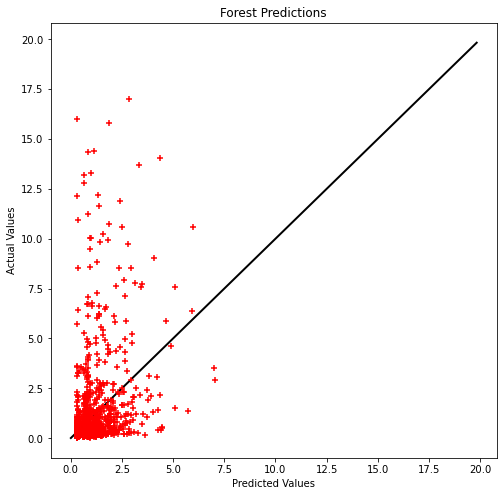

In [178]:
Forest_preds = FOREST.predict(X_TeSc)

plt.figure(figsize=(8, 8))
plt.scatter(Forest_preds, y_Test, s=30, c='r', marker='+', zorder=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c='k', lw=2)
plt.title("Forest Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [70]:
GRADIENT.feature_importances_

array([0.01084565, 0.00020976, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [73]:
Gradient_importances = pd.DataFrame(list(zip(X.columns, GRADIENT.feature_importances_)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)
Gradient_importances

,Feature,Importance
3,views_past_week,0.232251
61,set_rarities_Secret Rare,0.087507
48,set_rarities_Common,0.085577
68,set_rarities_Ultra Rare,0.077791
3261,head,0.016142
...,...,...
1831,calculation opponent's,0.000000
1830,calculation monster,0.000000
1829,calculation either,0.000000
1828,calculation battles,0.000000


In [74]:
Gradient_importances[Gradient_importances.Importance>0]

,Feature,Importance
3,views_past_week,2.322508e-01
61,set_rarities_Secret Rare,8.750710e-02
48,set_rarities_Common,8.557723e-02
68,set_rarities_Ultra Rare,7.779110e-02
3261,head,1.614193e-02
...,...,...
43,type_Warrior,1.972111e-06
5266,utopia monster,1.610843e-06
1690,banished,1.321527e-06
2813,field,1.248072e-07


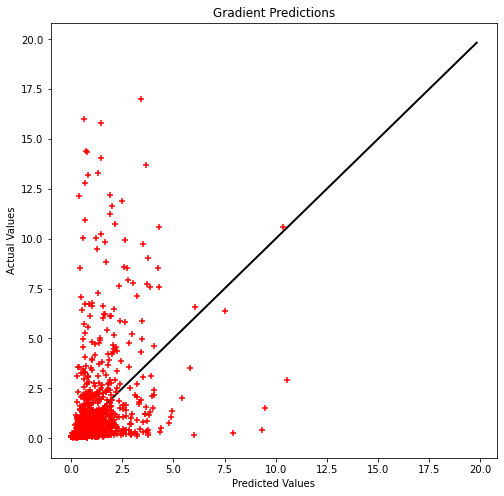

In [75]:
Gradient_preds = GRADIENT.predict(X_TeSc)

plt.figure(figsize=(8, 8))
plt.scatter(Gradient_preds, y_Test, s=30, c='r', marker='+', zorder=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c='k', lw=2)
plt.title("Gradient Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

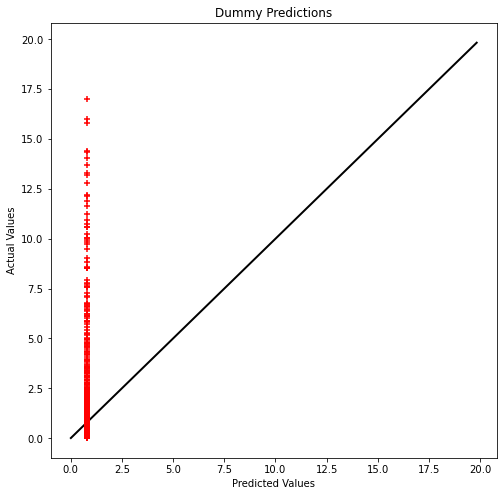

In [179]:
#for comparison with the others we can also display the dummy model graphically

Dummy_preds = dum.predict(X_TeSc)

plt.figure(figsize=(8, 8))
plt.scatter(Dummy_preds, y_Test, s=30, c='r', marker='+', zorder=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c='k', lw=2)
plt.title("Dummy Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

### Conclusions and Future Direction of the Project

In [ ]:
#summarise results and discuss future improvements, what went well? what didn't?